# Project 2 - COSC 528
## October 22, 2018
## Author: Ian R. Stewart

In [1]:
import pandas as pd
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore")

# importing SVD library to extract PCs
from scipy.linalg import svd

# plotting libraries
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
inPath = '/Users/i6o/Documents/COSC 528/Project 2/'
df = pd.read_excel(inPath+'UTK-peers.xlsx')

Dropping empty rows from imported file

In [3]:
first_row_with_all_NaN = df.shape[0]-df[df.isnull().all(axis=1) == True].shape[0]
df = df.loc[0:first_row_with_all_NaN-1]

Dropping unique features from dataframe

In [4]:
df = df.drop(['IPEDS#','HBC','Carm R1'],axis=1)

Searching for empty data entries in features

In [5]:
count = 0; indexes = []
for i in df.isnull().any():
    if i == True:
        indexes.append(count)
    count+=1
print df.columns.values[indexes]

[u'2014 Med School' u'Vet School' u'Endowment' u'Wall St. Jourl Rank'
 u'Enowment / St. FTE' u'AG Research ($000)']


Inserting correct WSJ College Rankings from following reference: https://www.timeshighereducation.com/sites/default/files/breaking_news_files/wsj-the-college-rankings-2017-results.pdf

University with partial names, such 'Utah', were confirmed to be specific universities via the IPEDS number.

In [6]:
df['Wall St. Jourl Rank'][df['Name']=='Delaware']=137
df['Wall St. Jourl Rank'][df['Name']=='Colorado State']=353
df['Wall St. Jourl Rank'][df['Name']==' Arizona State']=131
df['Wall St. Jourl Rank'][df['Name']=='Georgia Tech']=51
df['Wall St. Jourl Rank'][df['Name']=='UC-Irvine']=153
df['Wall St. Jourl Rank'][df['Name']=='UC-San Diego']=49
df['Wall St. Jourl Rank'][df['Name']=='Connecticut']=110
df['Wall St. Jourl Rank'][df['Name']==' Iowa']=164
df['Wall St. Jourl Rank'][df['Name']=='Buffalo']=130
df['Wall St. Jourl Rank'][df['Name']=='Utah']=311
df['Wall St. Jourl Rank'][df['Name']=='UC-Riverside']=368
df['Wall St. Jourl Rank'][df['Name']==' Arizona']=162

In [7]:
df['2014 Med School'][df['2014 Med School']=='x']=1
df['2014 Med School'][df['2014 Med School']=='pre clin']=1
df['2014 Med School'][df['2014 Med School']!=int(1)]=0
df['Vet School'][df['Vet School']!='x']=0
df['Vet School'][df['Vet School']=='x']=1
df['Endowment'][df['Name']=='Clemson Univ.']=621.3E6

In [8]:
count = 0; indexes = []
for i in df.isnull().any():
    if i == True:
        indexes.append(count)
    count+=1
print 'Feautures with missing data: %s'%df.columns.values[indexes]

Feautures with missing data: [u'Enowment / St. FTE' u'AG Research ($000)']


Error in feature label. Fixing typo of label "Enowment / St. FTE" to "Endowment / St. FTE"

In [9]:
df.rename(columns={"Enowment / St. FTE":"Endowment / St. FTE"},inplace=True)

Fixing NaN value in Endowment / St. FTE ; It should be noted that after checking the other values for this feature, the Endowment divided by St. FTE is *NOT* exactly the reported value in the provided data.

In [10]:
count = 0
for i in df["Endowment / St. FTE"]:
    j = str(i)
    if j == "nan":
        name = df['Name'][count]
        endowment = df['Endowment'][df['Name']==name]
        fte = df['ST. FTE'][df['Name']==name]
        df["Endowment / St. FTE"][df['Name']==name]=int(endowment / fte)
    count+=1

With many missing values and poor reporting for the AG (assume agricultural) research expenditures, the feature has been dropped from the analysis.

In [11]:
df = df.drop(['AG Research ($000)'],axis=1)

Re-verifying that all features have are filled with no missing data.

In [12]:
count = 0; indexes = []
for i in df.isnull().any():
    if i == True:
        indexes.append(count)
    count+=1
print 'Feautures with missing data: %s'%df.columns.values[indexes]

Feautures with missing data: []


Fixing data types on manipulated data feautures.

In [13]:
df['Name']=df['Name'].astype('|S')
df['Vet School']=df['Vet School'].astype(float)
df['2014 Med School']=df['2014 Med School'].astype(float)

Now that the data has been explored with appropriate handling of the unique features and missing data, let's create a data matrix containing soley the numeric attributes for analysis.

In [14]:
analysis = df.iloc[:,1::] # Essentially, we are only dropping the university name

In [15]:
analysis.shape

(57, 60)

Mean-centering the data prior to analysis.

In [16]:
# Centering each data feature
a_centered=(analysis.iloc[:,0::]-analysis.iloc[:,0::].mean())

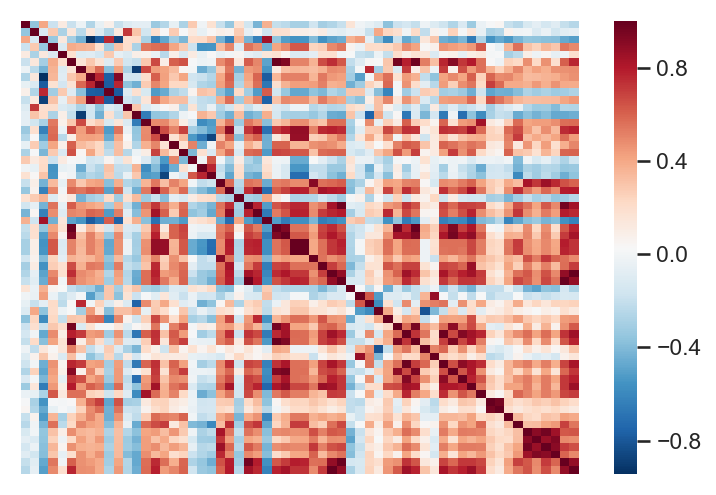

In [17]:
# Exploring correlation matrix
cols = list(a_centered.columns.values)
corr = np.corrcoef(a_centered.values.T)
plt.figure(dpi=150)
sns.set(font_scale=1.0)
sns.heatmap(corr,cbar=True,cmap="RdBu_r",yticklabels=[],xticklabels=[])

### **Analysis**

Finding factorized matrices from created analysis matrix. For the matrix **Analysis** with (*57x60*), the expected sizes of the factorized matrices are as follows: **U**(*57x57*), **Sigma**(*57x60*), and **VT**(*60x60*). Of note, the package utilized here (SciPy.linalg.SVD) outputs a single column (57-length vector) for **Sigma**, which is a diagonal matrix. These values are known as the singular values of the original matrix **Analysis**, while **U** and **VT** are referred to as the left-singular and right-singular vectors of **Analysis**, respectively.

In [48]:
U, Sigma, VT = svd(a_centered)

In [40]:
# Verifying shape of SVD from SciPy.linalg.SVD function
U.shape,Sigma.shape,VT.shape

((57, 57), (57,), (60, 60))

Now that the matrix decomposition is complete, we must find the optimal threshold for the number of dimensions to retain. To assist in making this decision, we can create a Scree plot to visualize the data. Of note, the variance is calculated by squaring the singular values (i.e. values in **Sigma** vector).

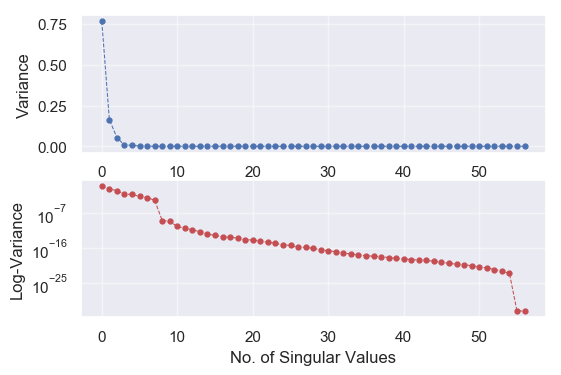

In [41]:
# Creating Scree plot
fig, (ax,ax1) = plt.subplots(nrows=2,dpi=100)
variance_sigma = Sigma**2/np.cumsum(Sigma**2)[-1]
ax.plot(variance_sigma,'o--',markersize=3.5,linewidth=0.75)
ax.grid(alpha=0.5)
ax.set_ylabel('Variance')
ax1.plot(variance_sigma,'ro--',markersize=3.5,linewidth=0.75)
ax1.set_ylabel('Log-Variance')
ax1.set_xlabel('No. of Singular Values')
ax1.set_yscale('log')
ax1.grid(which='both',alpha=0.5)

Comparing results for Explained Variance for Singular Values and Scikit-Learn PCA function (only for comparison purposes!)

In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(a_centered)
print '\t\t\t\t\t\t\tSVD Method\tPCA Method'
print 'Percentage of Variance by the first value:\t\t%.3f %%\t%.3f %%'%(np.sum(variance_sigma[0:1])*100,pca.explained_variance_ratio_[0]*100)
print 'Percentage of Variance by the first two values:\t\t%.3f %%\t%.3f %%'%(np.sum(variance_sigma[0:2])*100,np.sum(pca.explained_variance_ratio_[0:2])*100)
print 'Percentage of Variance by the first three values:\t%.3f %%\t%.3f %%'%(np.sum(variance_sigma[0:3])*100,np.sum(pca.explained_variance_ratio_[0:3])*100)
print 'Percentage of Variance by the first four values:\t%.3f %%\t%.3f %%'%(np.sum(variance_sigma[0:4])*100,np.sum(pca.explained_variance_ratio_[0:4])*100)

							SVD Method	PCA Method
Percentage of Variance by the first value:		76.625 %	76.625 %
Percentage of Variance by the first two values:		93.041 %	93.041 %
Percentage of Variance by the first three values:	98.380 %	98.380 %
Percentage of Variance by the first four values:	99.115 %	99.115 %


From the results, the first two principal components capture ~93% of the total data variability. We will use two PCs moving forward

In [49]:
def getValues(n,V_transpose):
    '''
    @param n:           {int}   desired number of components
    @param V_transpose: {array} array matrix from SVD function
    return: original V function specified number of components
    '''
    V = V_transpose.T
    return V[:,0:n]

In [50]:
V = getValues(2,VT)

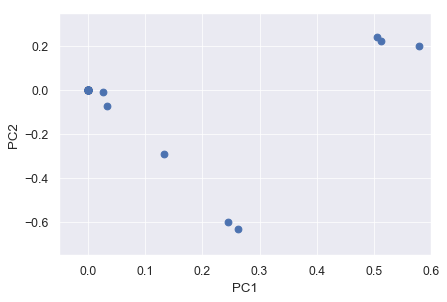

In [37]:
fig,ax = plt.subplots(dpi=80);
plt.scatter(V[:,0:1],V[:,1:2]);
ax.grid(alpha=0.75)
ax.set_axisbelow(True)
ax.set_ylim(-0.75,0.350);ax.set_xlim(-0.05,0.6)
ax.set_xlabel('PC1');ax.set_ylabel('PC2');

### **Creating Class for** ***K-Means*** **Calculation on decomposed data***

In [111]:
class K_means:
    '''
    This do k_means on some foolish dataset that don't need no man bc it is iid and strong.
    e.g. 
        a = K_means(2) # Two clusters
        a.main(data)   # calc. clusters and centroids
        a.centroids    # cluster centroid values
        a.clusters     # values in clusters
    '''
    
    def __init__(self,k=3,tol=0.0001,max_iter=int(2e3)):
        '''
        @param k:         {int}   number of clusters
        @param tol:       {float} convergence tolerance to stop iterations
        @param max_iter:  {float} maximum no. of iterations if not converged prior
        '''
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
    
    def main(self,data):
        '''
        Decsription: Performing main function for K_mean algorithm.
            1. Initial guess for cluster centroids
            2. Initial number of cluster from provided <self.k> parameter
            3. Iterate over data:
                3.1. Calculate distance between current datum and cluster centroids
                3.2. Choose cluster with minimum distance between datum and centroid
                3.3. Update cluster centroid based on new data
                3.4. Continue to next datum in data
            4. return data clusters and centroids
            5. rerun process next iteration until convergence
                5.1. convergence 
        '''
        # Initializing centroids
        self.centroids = {}
        for i in range(self.k):
            self.centroids[i] = data[i]
        
        # Iterate of Data
        for i in range(self.max_iter):
            self.clusters = {}
            for i in range(self.k):
                self.clusters[i] = []

            # Calculating distance and choosing nearest class centroid
            for features in data:
                distances = [np.linalg.norm(features - self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.clusters[classification].append(features)
            
            old_values = dict(self.centroids) # Storing values for later convergence testing

            for classification in self.clusters:
                self.centroids[classification] = np.average(self.clusters[classification], axis = 0)

            converged = True # boolean check value for convergence

            for centroid in self.centroids:

                old_c = old_values[centroid]
                new_c = self.centroids[centroid]

                # Checking if difference between centroids meet defined tolerance value
                if np.sum((new_c-old_c)/old_c*100.)>self.tol:
                    converged = False


            # If centroid calc. converged==True --> break loop
                if converged: 
                    break
    

Initializing class object with number of clusters

In [122]:
kmeans = K_means(3)

In [123]:
kmeans.main(V)

Plotting K-means clustering results from data

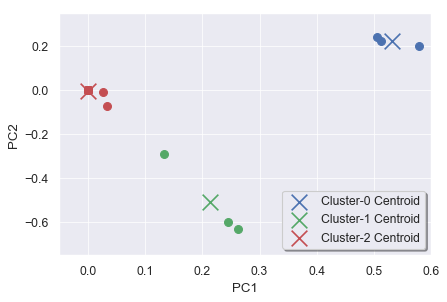

In [124]:
c = ['b','g','r','c','m','y','k','w'] # python default plot colors for clusters
fig,ax = plt.subplots(dpi=80)
for classification in kmeans.clusters:
    color = c[classification]
    for features in kmeans.clusters[classification]:
        ax.scatter(features[0], features[1], color = color,s = 50)
        
count=0
for centroid in kmeans.centroids:
    legend_string = 'Cluster-%i Centroid'%count
    ax.scatter(kmeans.centroids[centroid][0], kmeans.centroids[centroid][1],s=200, marker="x",color=c[count],label=legend_string)
    count+=1
ax.legend(loc='lower right',fancybox=True,shadow=True)
ax.grid(alpha=0.75)
ax.set_axisbelow(True)
ax.set_ylim(-0.75,0.350);ax.set_xlim(-0.05,0.6)
ax.set_xlabel('PC1');ax.set_ylabel('PC2');

In [130]:
kmeans_full = K_means()
a = np.array(a_centered)
kmeans_full.main(a)

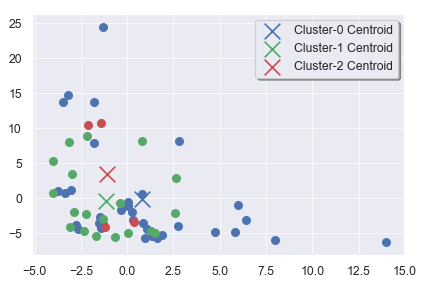

In [134]:
c = ['b','g','r','c','m','y','k','w'] # python default plot colors for clusters
fig,ax = plt.subplots(dpi=80)
for classification in kmeans_full.clusters:
    color = c[classification]
    for features in kmeans_full.clusters[classification]:
        ax.scatter(features[0], features[1], color = color,s = 50)
        
count=0
for centroid in kmeans_full.centroids:
    legend_string = 'Cluster-%i Centroid'%count
    ax.scatter(kmeans_full.centroids[centroid][0], kmeans_full.centroids[centroid][1],s=200, marker="x",color=c[count],label=legend_string)
    count+=1
ax.legend(loc='best',fancybox=True,shadow=True)
ax.grid(alpha=0.75)
ax.set_axisbelow(True)